<a href="https://colab.research.google.com/github/aminaalavi/AI-Projects/blob/main/AG2_Swarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Multi-Agent Investment Research Swarm with Autogen/AG2 Agents

In this notebook, we explore how to create a swarm of intelligent agents that collaboratively analyze a stock using the AG2 (Autogen) framework.

A **swarm** in the context of AG2 refers to a team of **conversable agents** that communicate and coordinate intelligently to perform tasks, similar to a team of human collaborators. Each agent is specialized, follows defined rules (policies), and can pass work between one another using well-orchestrated handoffs.

AG2 makes this lightweight and modular, enabling you to build and manage swarms for various workflows.

This swarm includes agents that:
- Analyze financial data
- Assess market sentiment
- Perform valuations
- Identify risk factors
- Generate reports and visualizations

It has been setup in Google Colab for everyone to follow easily.

The functions in this notebook (e.g., analyze_financials, perform_valuation, detect_risks) are simplified examples meant to illustrate how each agent interacts with external data. In real world, these functions would be significantly more complex

### 1. Install and Import Libraries
The following libraries are required to set up and run the AI agents. Ensure that all dependencies are installed before proceeding.

- `ag2[openai]`: The AG2 (Autogen) framework for building conversational agents and swarms.
- `yfinance`: A wrapper for Yahoo Finance used to fetch stock data and news.

In [1]:
!pip install -U ag2[openai] -q
!pip install yfinance -q # to get financial data
import yfinance as yf
import os
import openai
import json
import autogen
from google.colab import drive
drive.mount('/content/drive')
from google.colab import userdata



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.4/730.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.1 MB/s eta 0:00:00
Mounted at /content/drive


## Importing AG2 Swarm Utilities

Here we import the core AG2/Autogen components that enable swarm functionality:
- `ConversableAgent`: Defines an LLM powered agent.
- `register_hand_off` & `OnCondition`: Allow agents to pass tasks between each other.
- `initiate_swarm_chat`: Starts the multi-agent conversation with handoffs.


In [2]:
from autogen import (
    config_list_from_json,
    ConversableAgent,
    OnCondition,
    register_hand_off,
    initiate_swarm_chat,
    UserProxyAgent,
    AfterWorkOption
)

## Configuring OpenAI API Keys and Models

This section sets up API access to OpenAI models, ensuring secure authentication and smooth interaction with OpenAI's services.

#### API Key Configuration
- The OpenAI API key must be stored in Google Colab Secrets Manager before running this notebook. Also make sure your notebook has access to the Google Secrets

In [3]:
# Configuring OpenAI API Keys and Models
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
config_list = [
    {
        "model": "gpt-4o-mini",
        "api_key": os.environ["OPENAI_API_KEY"]
        },
    {
        "model": "gpt-4o",
        "api_key": os.environ["OPENAI_API_KEY"]
    }
]

# Save to file
with open("/content/OAI_CONFIG_LIST.json", "w") as f:
    json.dump(config_list, f)

## Loading OpenAI Configuration from JSON

This section loads the OpenAI API configuration from a JSON file and specifies the models to use .

In [4]:
# set config path
config_path = "/content/OAI_CONFIG_LIST.json"
config_list = autogen.config_list_from_json(
    config_path, filter_dict={"model": ["gpt-4o-mini"]} #you can use any model of your choice. Make sure it is in the config file
)
os.environ["OAI_CONFIG_LIST"] = "/content/OAI_CONFIG_LIST.json"

## Configuring

This section defines the **LLM configuration**

*   config_list: config_list → Uses the pre-defined list of LLM configurations to select the appropriate model.

In [5]:
# llm config
llm_config = {"cache_seed": 42,  "temperature": 1, "config_list": config_list, "timeout": 120, "tools": [],}


### Function 1 - Analyzing Financials

This function, `analyze_financials`, is called by the **Financials Agent** in the swarm.

It uses the `yfinance` library to:
- Create a `Ticker` object using the provided symbol (e.g., "AAPL")
- Fetch financial details via `.info`


In [6]:

def analyze_financials(ticker: str) -> str:
    stock = yf.Ticker(ticker)
    info = stock.info

    try:
        pe_ratio = info.get("trailingPE", "N/A")
        debt_to_equity = info.get("debtToEquity", "N/A")
        revenue_growth = info.get("revenueGrowth", "N/A")
        return (
            f"Financials for {ticker}:\n"
            f"• P/E Ratio: {pe_ratio}\n"
            f"• Debt/Equity: {debt_to_equity}\n"
            f"• Revenue Growth: {revenue_growth}"
        )
    except Exception as e:
        return f"Failed to fetch financials: {str(e)}"


### Function 2 : Assessing Market Sentiment

This function, used by the **Sentiment Agent**, simulates what a human investor might do when scanning headlines.

Here’s what it does:
- Fetches recent news articles using Yahoo Finance’s `.news` feature.
- Extracts the top 5 article titles.
- Constructs a **prompt** for the LLM to interpret sentiment based on those headlines. This showcases how agents can blend structured scraping (headlines) with human-like interpretation (LLM insight).



In [7]:
def assess_market_sentiment(ticker: str) -> list:
    stock = yf.Ticker(ticker)
    news = stock.news

    if not news:
        return [f"No recent news found for {ticker}."]

    # Safely collect headlines with fallback if 'title' is missing
    headlines = [article.get("title", "[No title available]") for article in news[:5]]
    return headlines



### Function 3: Performing Valuation

This function is run by the **Valuation Agent** and provides a basic financial overview of whether a stock is fairly priced.


In [8]:
def perform_valuation(ticker: str) -> str:
    stock = yf.Ticker(ticker)
    info = stock.info
    try:
        current_price = info.get("currentPrice", "N/A")
        forward_pe = info.get("forwardPE", "N/A")
        price_to_book = info.get("priceToBook", "N/A")
        fair_value_estimate = "Estimated using DCF and peer comparison (manual inputs may be needed)."
        return (
            f"Valuation for {ticker}:\n"
            f"• Current Price: {current_price}\n"
            f"• Forward P/E: {forward_pe}\n"
            f"• Price-to-Book Ratio: {price_to_book}\n"
            f"• {fair_value_estimate}"
        )
    except Exception as e:
        return f"Failed to fetch valuation data for {ticker}: {str(e)}"


### Function 4: Detecting Risks

The **Risk Agent** uses this function to simulate a basic risk review of a company.


In [9]:
def detect_risks(ticker: str) -> str:
    stock = yf.Ticker(ticker)
    info = stock.info
    try:
        beta = info.get("beta", "N/A")
        sector = info.get("sector", "N/A")
        country = info.get("country", "N/A")
        earnings_date = info.get("earningsDate", "N/A")
        risk_notes = (
            f"• Sector: {sector}\n"
            f"• Country: {country}\n"
            f"• Beta (Volatility): {beta}\n"
            f"• Upcoming Earnings Date: {earnings_date}\n"
            f"• Potential Risks: Market fluctuations, competition, geopolitical factors, and upcoming earnings volatility."
        )
        return f"Risk assessment for {ticker}:\n{risk_notes}"
    except Exception as e:
        return f"Failed to fetch risk data for {ticker}: {str(e)}"

### Function 5:  Generating a Summary Report

This function is called by the **Summary Agent** at the end of the swarm workflow.

It does not fetch new data .Instead, it **formats and compiles** insights that previous agents have generated:
- Financials
- Sentiment
- Valuation
- Risks


In [10]:
def generate_summary_report(ticker: str) -> str:
    return (
        f"===== INVESTMENT SUMMARY: {ticker.upper()} =====\n"
        f"\n[1] Financial Overview:\n{{financials_summary}}\n"
        f"\n[2] Market Sentiment:\n{{sentiment_summary}}\n"
        f"\n[3] Valuation Insights:\n{{valuation_summary}}\n"
        f"\n[4] Risk Factors:\n{{risk_summary}}\n"
        f"\n[5] Final Analyst Summary:\nThis stock shows {{insert_LLManalysis}} based on current data.\n"
        f"============================================="
    )


### Plotting the Stock Price

This function is used by the **Summary Agent** to add a visual element to the analysis.

What it does:
- Uses `yfinance` to download 6 months of daily stock prices.
- Uses `matplotlib` to create a clean line chart of closing prices.
- Saves the chart as a PNG image.
- Displays the image **inline in the notebook** using `IPython.display`.

Tip: This is where AG2 swarms can go beyond conversation and start generating rich content like charts and visual insights.


In [11]:
import yfinance as yf
import matplotlib.pyplot as plt


def plot_stock_price(ticker: str):
    import IPython.display as display
    data = yf.download(ticker, period="6mo", interval="1d")
    data['Close'].plot(title=f"{ticker.upper()} Stock Price (6M)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.grid(True)
    plt.tight_layout()
    file_path = f"{ticker}_price.png"
    plt.savefig(file_path)
    plt.close()
    display.display(display.Image(filename=file_path))
    return f"Displayed stock price chart for {ticker}."f"Saved stock price chart for {ticker} as {ticker}_price.png"

### Agent System Messages

In [12]:
# ----------------------------
# Agent System Messages
# ----------------------------

STARTER_PROMPT = """You are an intelligent investment research assistant focused on analyzing a stock.
Follow your specific policy steps carefully before handing off or concluding.
Work only within your area of expertise and call a function once your task is complete.
Here is your policy:
"""

# Agent-specific prompts
FINANCIALS_POLICY = """
1. Analyze income statement, balance sheet, and cash flow.
2. Extract key metrics: revenue growth, net margin, P/E ratio, debt levels.
3. Call analyze_financials function once complete.
4. Pass control to Sentiment Agent.
"""

SENTIMENT_POLICY = """
1. Use the assess_market_sentiment function to retrieve recent headlines.
2. Review the content and tone of the headlines carefully.
3. Based on their tone, classify sentiment as Positive, Neutral, or Negative.
4. Explain your reasoning using examples from the headlines.
5. Pass control to Valuation Agent.
"""

VALUATION_POLICY = """
1. Use DCF and comparable company analysis.
2. Compare current price to fair value estimate.
3. Call perform_valuation function.
4. Pass control to Risk Agent.
"""

RISK_POLICY = """
1. Identify risk factors: industry trends, competition, volatility.
2. Call detect_risks function once done.
3. Pass control to Summary Agent.
"""

SUMMARY_POLICY = """
1. Review outputs from all agents.
2. Compile insights into a cohesive report.
3. Call generate_summary_report function.
# 4. Generate a 6-month price chart.
# 5. Call the plot_stock_price function.
"""





###  Defining Conversable Agents

Each agent is created using `ConversableAgent` and given:
- A `name`
- A `system_message` that acts as its policy (what it's supposed to do)
- Access to the shared `llm_config`
- A list of functions it can call

📋 Here's what each agent does:
- **Financials Agent** → Analyzes raw financial metrics
- **Sentiment Agent** → Reviews news and interprets tone
- **Valuation Agent** → Estimates stock value based on financial ratios
- **Risk Agent** → Summarizes major risk factors
- **Summary Agent** → Compiles everything into a readable investment memo and displays the final chart

This is where you modularize your workflow and assign each task to a specialist LLM agent.


In [13]:
# ----------------------------
# Agent Definitions
# ----------------------------

financials_agent = ConversableAgent(
    name="Financials_Agent",
    system_message=STARTER_PROMPT + FINANCIALS_POLICY,
    llm_config=llm_config,
    functions=[analyze_financials]
)

sentiment_agent = ConversableAgent(
    name="Sentiment_Agent",
    system_message=STARTER_PROMPT + SENTIMENT_POLICY,
    llm_config=llm_config,
    functions=[assess_market_sentiment]
)

valuation_agent = ConversableAgent(
    name="Valuation_Agent",
    system_message=STARTER_PROMPT + VALUATION_POLICY,
    llm_config=llm_config,
    functions=[perform_valuation]
)

risk_agent = ConversableAgent(
    name="Risk_Agent",
    system_message=STARTER_PROMPT + RISK_POLICY,
    llm_config=llm_config,
    functions=[detect_risks]
)

summary_agent = ConversableAgent(
    name="Summary_Agent",
    system_message=STARTER_PROMPT + SUMMARY_POLICY,
    llm_config=llm_config,
    functions=[generate_summary_report, plot_stock_price]
)

### The Agent Workflow

This section sets up the **handoff logic**, determining when each agent should pass control to the next.

We use `register_hand_off()` and `OnCondition()` from AG2 to:
- Ensure agents complete their task before passing off
- Trigger agents based on the task's natural flow (financials → sentiment → valuation → risk → summary → chart)

The power of swarms is in this choreography. No need for loops or state machines. The agents pass tasks intelligently.


In [14]:
# ----------------------------
# Agent Handoffs
# ----------------------------

register_hand_off(financials_agent, OnCondition(sentiment_agent, "To assess market sentiment."))
register_hand_off(sentiment_agent, OnCondition(valuation_agent, "To perform valuation."))
register_hand_off(valuation_agent, OnCondition(risk_agent, "To identify risks."))
register_hand_off(risk_agent, OnCondition(summary_agent, "To compile a summary report and generate visual report."))

### Initiating the Swarm Chat

This is where the magic happens.

We:
1. Define the **user agent** (you)
2. Call `initiate_swarm_chat()` with:
   - The **initial agent** (Financials Agent)
   - The full list of collaborating agents
   - The starting **user prompt**: `"Please analyze "ticker" for me"`


User (to chat_manager):

Please analyze NVDA for me.

--------------------------------------------------------------------------------

Next speaker: Financials_Agent


>>>>>>>> USING AUTO REPLY...
Financials_Agent (to chat_manager):

***** Suggested tool call (call_ENQaZIop3trOVGFkies5ldR2): analyze_financials *****
Arguments: 
{"ticker":"NVDA"}
***********************************************************************************

--------------------------------------------------------------------------------

Next speaker: _Swarm_Tool_Executor


>>>>>>>> EXECUTING FUNCTION analyze_financials...
Call ID: call_ENQaZIop3trOVGFkies5ldR2
Input arguments: {'ticker': 'NVDA'}
_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_ENQaZIop3trOVGFkies5ldR2) *****
Financials for NVDA:
• P/E Ratio: 32.078228
• Debt/Equity: 12.946
• Revenue Growth: 0.779
**********************************************************************

------------------------------------------------

[*********************100%***********************]  1 of 1 completed


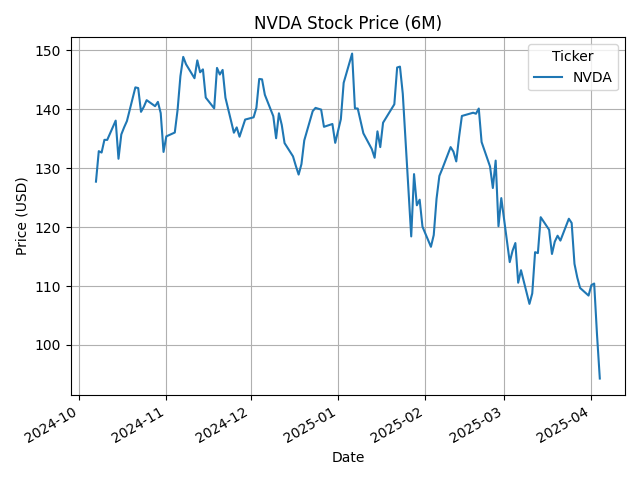

_Swarm_Tool_Executor (to chat_manager):

***** Response from calling tool (call_g5LUkNJdL37KJeNHL2jxC3LD) *****
===== INVESTMENT SUMMARY: NVDA =====

[1] Financial Overview:
{financials_summary}

[2] Market Sentiment:
{sentiment_summary}

[3] Valuation Insights:
{valuation_summary}

[4] Risk Factors:
{risk_summary}

[5] Final Analyst Summary:
This stock shows {insert_LLManalysis} based on current data.
**********************************************************************

--------------------------------------------------------------------------------
***** Response from calling tool (call_jUl4G4dCiFmU3a3x0rTWbA8h) *****
Displayed stock price chart for NVDA.Saved stock price chart for NVDA as NVDA_price.png
**********************************************************************

--------------------------------------------------------------------------------

Next speaker: Summary_Agent


>>>>>>>> USING AUTO REPLY...
Summary_Agent (to chat_manager):

### NVDA Investment Analysis Report

In [15]:
# ----------------------------
# Start the swarm with a human input
# ----------------------------

user = UserProxyAgent(
    name="User",
    system_message="Human investor or analyst",
    code_execution_config=False,
)

chat_history, context_variables, last_agent = initiate_swarm_chat(
    initial_agent=financials_agent,
    agents=[
        financials_agent,
        sentiment_agent,
        valuation_agent,
        risk_agent,
        summary_agent
    ],
    user_agent=user,
    messages="Please analyze NVDA for me.",
    after_work=AfterWorkOption.REVERT_TO_USER
)